# Notebook to convert the PASCAL format boxes annotations into TFRecords

    - ready to use in the TensorFlow object detection API
    - Code based on: https://github.com/tensorflow/models/blob/master/research/object_detection/create_pascal_tf_record.py  

In [1]:

import tensorflow as tf
import logging
import os
import io
import PIL.Image
import hashlib
import sys

from lxml import etree

import matplotlib.pyplot as plt
import matplotlib.patches as patches
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (20, 20)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels

In [2]:
# Import functions from the Object Detection API
tf_models_path  = '/home/ubuntu/projects/training/tensorflow/models/research/'

sys.path.append(tf_models_path)
sys.path.append(tf_models_path + "object_detection")

from object_detection.utils import dataset_util
from object_detection.utils import label_map_util


In [4]:
# Path to the images and anotations in XML
path = '/home/jorge/data/training/image/face_detection_dataset/'

# Path to the output TFRecord files
path_out = tf_models_path + 'object_detection/data/faces/'



{'Face': 1}


In [3]:
# Create TFRecod examples
def dict_to_tf_example(data,
                       dataset_directory,
                       label_map_dict,
                       ignore_difficult_instances=False):
    """Convert XML derived dict to tf.Example proto.

    Notice that this function normalizes the bounding box coordinates provided
    by the raw data.

    Args:
      data: dict holding PASCAL XML fields for a single image (obtained by
        running dataset_util.recursive_parse_xml_to_dict)
      dataset_directory: Path to root directory holding PASCAL dataset
      label_map_dict: A map from string label names to integers ids.
      ignore_difficult_instances: Whether to skip difficult instances in the
        dataset  (default: False).

    Returns:
      example: The converted tf.Example.

    Raises:
      ValueError: if the image pointed to by data['filename'] is not a valid JPEG
    """
    full_path = os.path.join(dataset_directory, data['filename'])
    
    with tf.gfile.GFile(full_path, 'rb') as fid:
        encoded_jpg = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_jpg)
    image = PIL.Image.open(encoded_jpg_io)
    if image.format != 'JPEG':
        raise ValueError('Image format not JPEG')
    key = hashlib.sha256(encoded_jpg).hexdigest()

    width = int(data['size']['width'])
    height = int(data['size']['height'])

    xmin = []
    ymin = []
    xmax = []
    ymax = []
    classes = []
    classes_text = []
    truncated = []
    poses = []
    difficult_obj = []
    if 'object' in data.keys(): 
        for obj in data['object']:
            difficult = bool(int(obj['difficult']))
            if ignore_difficult_instances and difficult:
                continue
            difficult_obj.append(int(difficult))
            xmin.append(float(obj['bndbox']['xmin']) / width )
            ymin.append(float(obj['bndbox']['ymin']) / height)
            xmax.append(float(obj['bndbox']['xmax']) / width )
            ymax.append(float(obj['bndbox']['ymax']) / height)
            classes_text.append(obj['name'].encode('utf8'))
            classes.append(label_map_dict[obj['name']])
            truncated.append(int(obj['truncated']))
            poses.append(obj['pose'].encode('utf8'))

    example = tf.train.Example(features=tf.train.Features(feature={
        'image/height':             dataset_util.int64_feature(height),
        'image/width':              dataset_util.int64_feature(width),
        'image/filename':           dataset_util.bytes_feature(data['filename'].encode('utf8')),
        'image/source_id':          dataset_util.bytes_feature(data['filename'].encode('utf8')),
        'image/key/sha256':         dataset_util.bytes_feature(key.encode('utf8')),
        'image/encoded':            dataset_util.bytes_feature(encoded_jpg),
        'image/format':             dataset_util.bytes_feature('jpeg'.encode('utf8')),
        'image/object/bbox/xmin':   dataset_util.float_list_feature(xmin),
        'image/object/bbox/xmax':   dataset_util.float_list_feature(xmax),
        'image/object/bbox/ymin':   dataset_util.float_list_feature(ymin),
        'image/object/bbox/ymax':   dataset_util.float_list_feature(ymax),
        'image/object/class/text':  dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
        'image/object/difficult':   dataset_util.int64_list_feature(difficult_obj),
        'image/object/truncated':   dataset_util.int64_list_feature(truncated),
        'image/object/view':        dataset_util.bytes_list_feature(poses),
    }))
    return example

In [ ]:
def dict_to_tf_example(data):
    #Read image
    with tf.gfile.GFile(data['image_path'], 'rb') as fid:
        encoded_jpg = fid.read()
    width = int(data['size']['width'])
    # Generate list of objects
    for obj in data['object']:
        classes.append(label_map_dict[obj['name']])
    # Create TFRecord example    
    example = tf.train.Example(features=tf.train.Features(feature={
        'image/width':             dataset_util.int64_feature(width),
        'image/encoded':            dataset_util.bytes_feature(encoded_jpg),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return example

In [ ]:
# Dictionary that assign an integer code (must start in 1, 0 is reserved) to the labels of the boxes
label_map_dict = label_map_util.get_label_map_dict(path + 'faces_label_map.pbtxt')

print(label_map_dict)

In [5]:

def create_tfrecord(annotations_dir, data_dir, output_path):
    
    # Create a new TFRecord file
    writer = tf.python_io.TFRecordWriter(output_path)

    #Read list of examples from annotations dictionary
    examples_list = [f.split('.')[0] for f in os.listdir(annotations_dir) if os.path.isfile(os.path.join(annotations_dir, f))]

    for idx, example in enumerate(examples_list):
        if idx % 1000 == 0:
            logging.info('On image %d of %d', idx, len(examples_list))

        # Read XML annotation file and load in into a XML tree structure
        path = os.path.join(annotations_dir, example + '.xml')
        with tf.gfile.GFile(path, 'r') as fid:
            xml_str = fid.read()
        xml = etree.fromstring(xml_str)

        # Convert XML tree into a python dictionary
        data = dataset_util.recursive_parse_xml_to_dict(xml)['annotation']
        
        # Convert python dictionary into a TFRecord row
        tf_example = dict_to_tf_example(data, data_dir, label_map_dict)

        # Write the TFRecod row into the TFRecord file
        writer.write(tf_example.SerializeToString())
    writer.close()
    print('Created TFRecord ', output_path)


In [6]:
# Create train TFRecords
create_tfrecord(os.path.join(path, 'train/annotations'), 
                os.path.join(path, 'train/images'),
                os.path.join(path_out, 'faces_train.record')
               )


Created TFRecord  /home/ubuntu/projects/training/tensorflow/models/research/object_detection/data/faces/faces_train.record


/home/ubuntu/projects/training/tensorflow/models/research/object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


In [7]:
# Create test TFRecords
create_tfrecord(os.path.join(path, 'test/annotations'), 
                os.path.join(path, 'test/images'),
                os.path.join(path_out, 'faces_eval.record')
               )


Created TFRecord  /home/ubuntu/projects/training/tensorflow/models/research/object_detection/data/faces/faces_eval.record


/home/ubuntu/projects/training/tensorflow/models/research/object_detection/utils/dataset_util.py:75: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  if not xml:


## Check the TFRecord content.

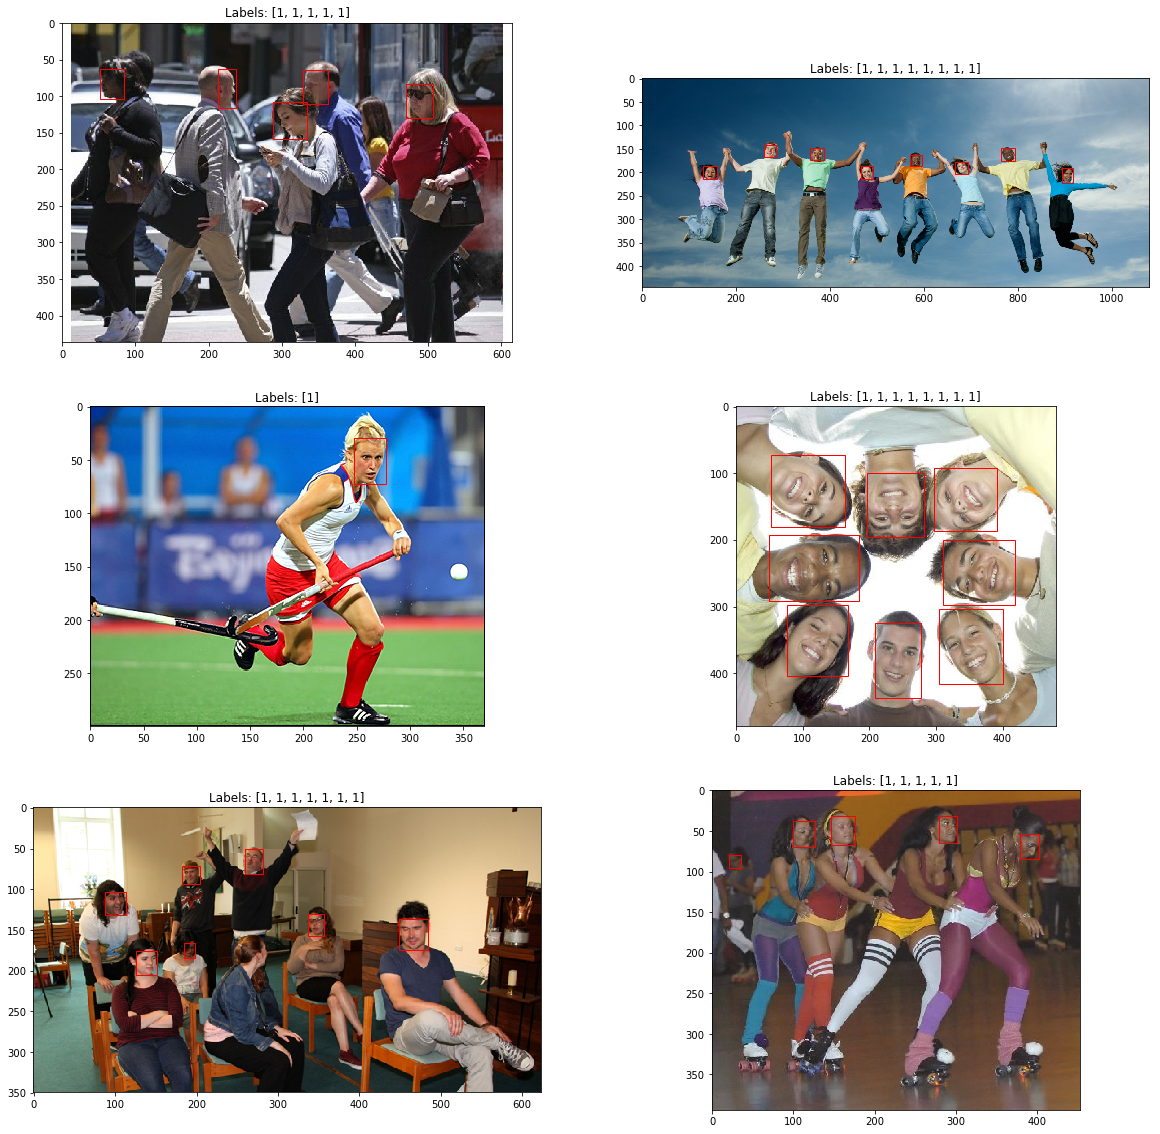

In [8]:

tfrecords_path = os.path.join(path_out, 'faces_eval.record')
                           
with tf.Session() as sess:
    feature = {'image/encoded': tf.FixedLenFeature([], tf.string),
               'image/object/bbox/xmin': tf.VarLenFeature(tf.float32),
               'image/object/bbox/xmax': tf.VarLenFeature(tf.float32),
               'image/object/bbox/ymin': tf.VarLenFeature(tf.float32),
               'image/object/bbox/ymax': tf.VarLenFeature(tf.float32),
               'image/object/class/label': tf.VarLenFeature(tf.int64)}
    
    # Create a list of filenames and pass it to a queue
    filename_queue = tf.train.string_input_producer([tfrecords_path], num_epochs=1)
    
    # Define a reader and read the next record
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    
    # Decode the record read by the reader
    features = tf.parse_single_example(serialized_example, features=feature)
    
    # Convert the image data from string back to the numbers
    image = features['image/encoded']
    xmin = features['image/object/bbox/xmin']
    xmax  = features['image/object/bbox/xmax']
    ymin = features['image/object/bbox/ymin']
    ymax  = features['image/object/bbox/ymax']
    label = features['image/object/class/label']
        
    # Initialize all global and local variables
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    
    # Create a coordinator and run all QueueRunner objects
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    
    # Plot extracted images and object boxes
    fig = plt.figure()
    for batch_index in range(6):
        img, x_min, x_max, y_min, y_max, l = sess.run([image, xmin, xmax, ymin, ymax, label])
        encoded_jpg_io = io.BytesIO(img)
        image_decoded = PIL.Image.open(encoded_jpg_io)
        ax = fig.add_subplot(3, 2, batch_index+1)
        
        # Create boxes
        for i in range(len(x_min[1])):
            x_rect = x_min[1][i]*image_decoded.width
            y_rect = y_min[1][i]*image_decoded.height
            x_incr = x_max[1][i]*image_decoded.width - x_rect
            y_incr = y_max[1][i]*image_decoded.height - y_rect
            rect = patches.Rectangle((x_rect,y_rect),x_incr,y_incr,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)

        ax.set_title('Labels: ' + str(list(l[1])))
        plt.imshow(image_decoded)
    # Stop the threads
    coord.request_stop()
    
    # Wait for threads to stop
    coord.join(threads)
    sess.close()